In [ ]:
import sklearn
import xgboost
print(f"Scikit-Learn Version: {sklearn.__version__}")
print(f"XGBoost Version: {xgboost.__version__}")


Scikit-Learn Version: 1.6.1
XGBoost Version: 1.7.6


In [ ]:
pip install xgboost==1.7.6


In [ ]:
import sklearn
print(sklearn.__version__)


1.6.1


In [ ]:
pip install scikit-learn==1.2.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 41.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


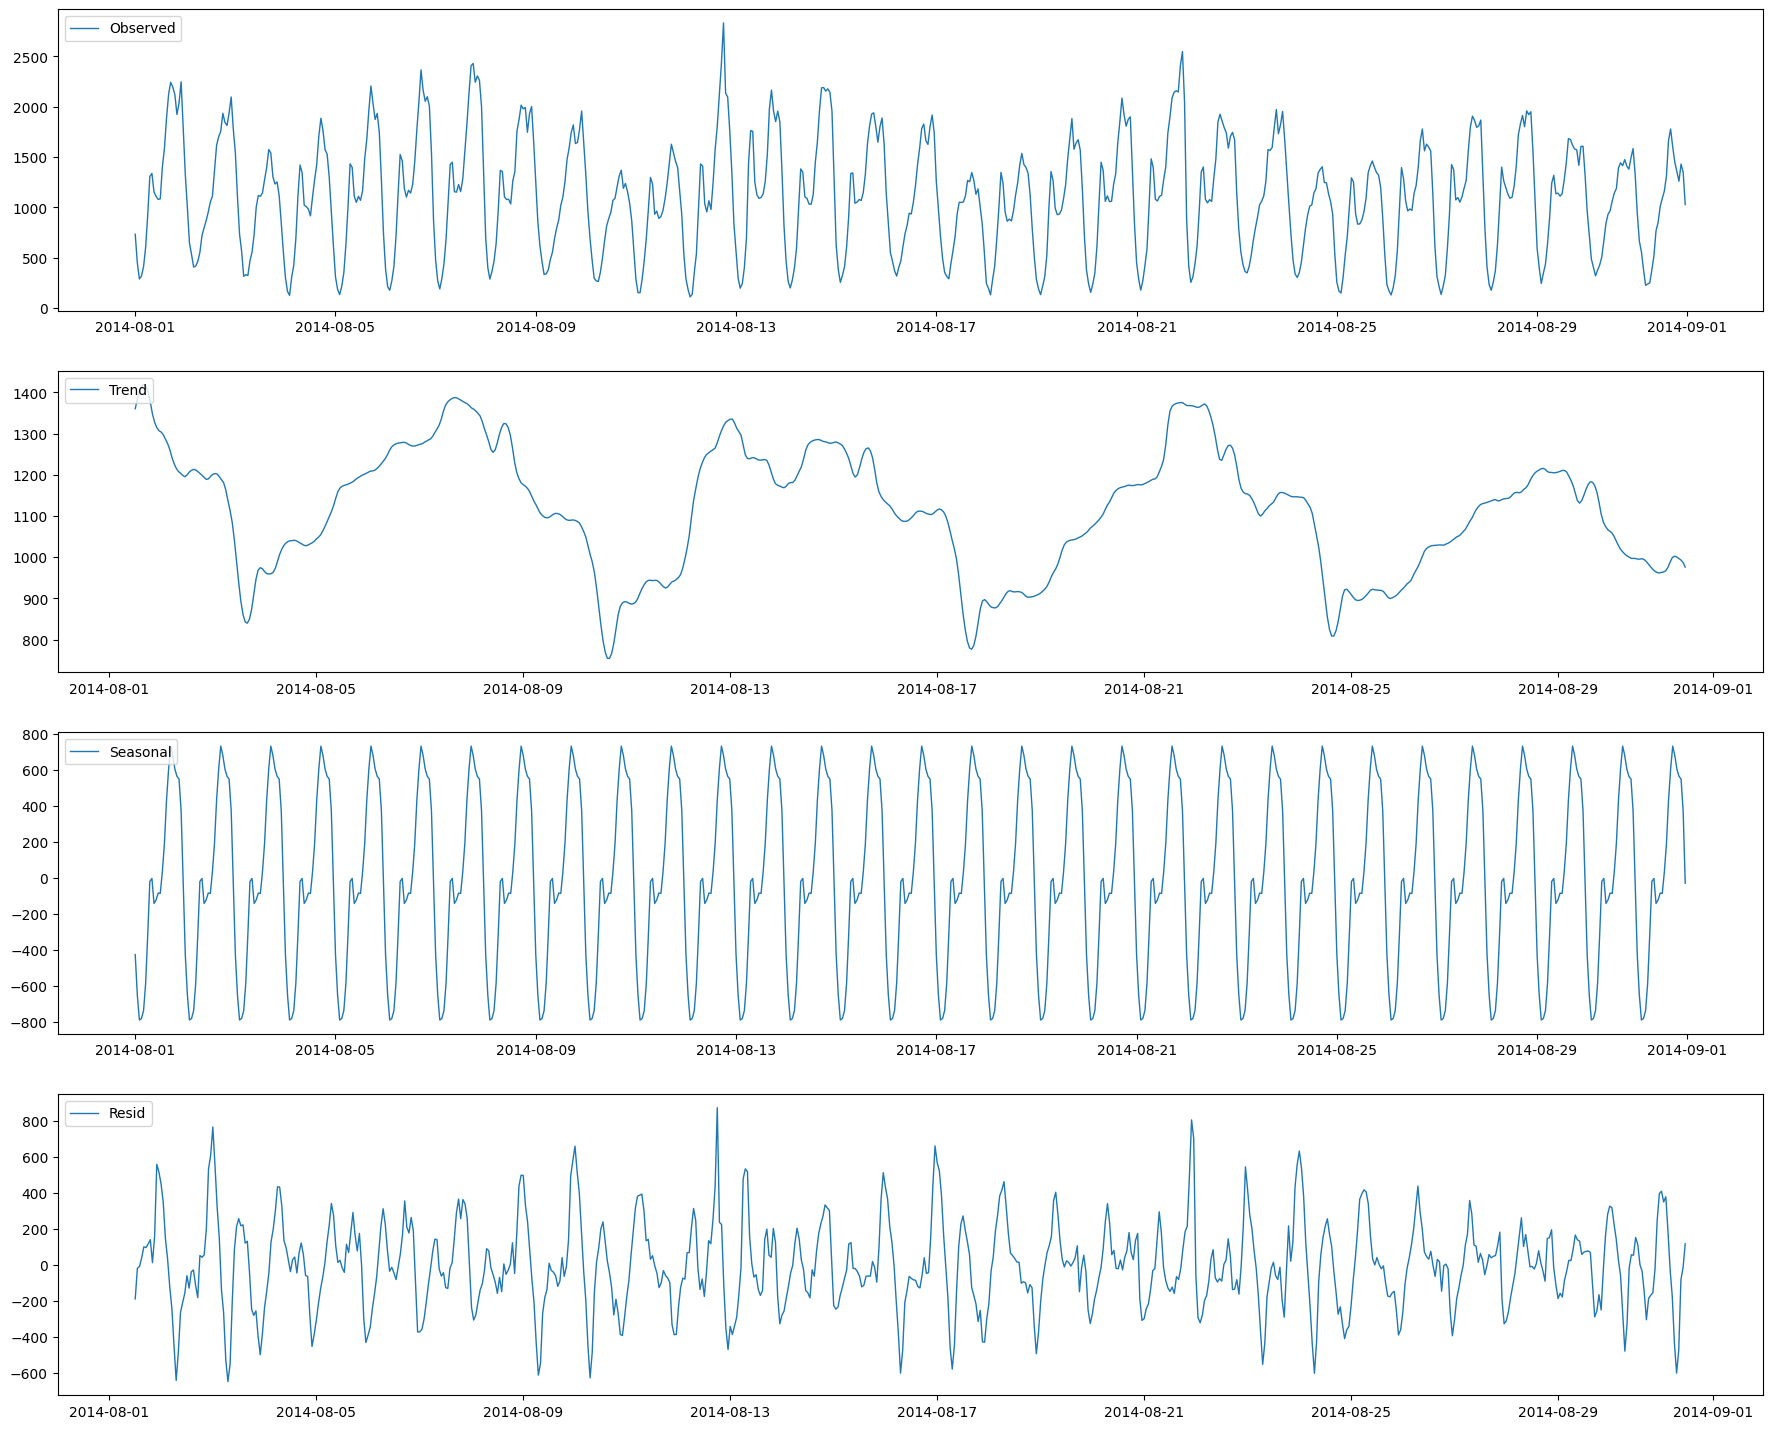

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
XGBoost MAPE: 8.93%
Random Forest MAPE: 8.56%
GBR MAPE: 10.15%


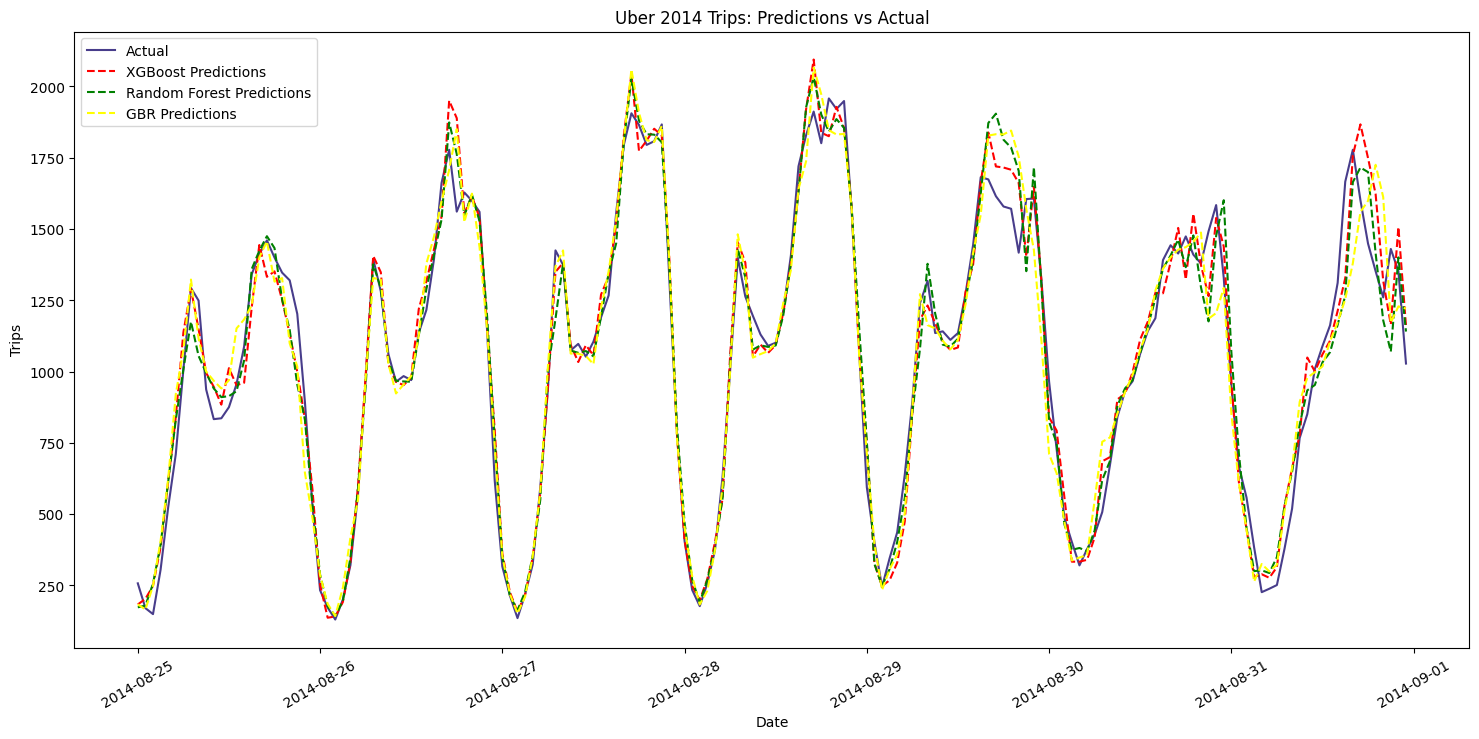

In [ ]:
#Hare krishna hare krishna krishna krishna hare hare hare rama hare rama rama hare hare
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import zipfile
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

# Function to plot decomposition
def plot_decomposition(result):
    plt.figure(figsize=(22, 18))
    components = ['observed', 'trend', 'seasonal', 'resid']
    for i, component in enumerate(components, 1):
        plt.subplot(4, 1, i)
        plt.plot(getattr(result, component), label=component.capitalize(), lw=1)
        plt.legend(loc='upper left')
    plt.show()

# Function to create lagged features
def create_lagged_features(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Extract ZIP file
data_zip = "uber-raw-data-aug14.csv.zip"
extract_to = "uber_data"

if not os.path.exists(extract_to):
    with zipfile.ZipFile(data_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Collect all CSV files in the extracted folder
files = [os.path.join(extract_to, filename)
         for filename in os.listdir(extract_to) if filename.endswith(".csv")]

# Load and combine CSV files
df_list = [pd.read_csv(file) for file in files]
df = pd.concat(df_list, ignore_index=True)

# Preprocessing
df['Date'] = pd.to_datetime(df['Date/Time'], format='%m/%d/%Y %H:%M:%S')
df.sort_values(by='Date', inplace=True)
df.set_index('Date', inplace=True)

# Resampling data hourly
uber2014 = df['Base'].resample('H').count().to_frame(name='Count')

# Seasonal decomposition
result = seasonal_decompose(uber2014['Count'], model='additive', period=24)
plot_decomposition(result)

# Train-Test Split based on trend observation
cutoff_date = '2014-08-25 00:00:00'
uber2014_train = uber2014.loc[:cutoff_date]
uber2014_test = uber2014.loc[cutoff_date:]

# Feature Engineering: Lagged Features
window_size = 24
X_train, y_train = create_lagged_features(uber2014_train['Count'].values, window_size)

# Prepare test data
test_data = np.concatenate([uber2014_train['Count'].values[-window_size:],
                            uber2014_test['Count'].values])
X_test, y_test = create_lagged_features(test_data, window_size)

# XGBoost Model
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

from xgboost import XGBRegressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=12345)


tscv = TimeSeriesSplit(n_splits=5)

xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=tscv,
                               scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

# Best Model Prediction
xgb_predictions = xgb_grid_search.best_estimator_.predict(X_test)

# Random Forest Model
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

rf_model = RandomForestRegressor(random_state=12345)
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=tscv,
                              scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Best Model Prediction
rf_predictions = rf_grid_search.best_estimator_.predict(X_test)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
gbr_param_grid = {
'n_estimators': [100, 200, 300],
'learning_rate': [0.01, 0.1],
'max_depth': [3, 4, 5],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4],
'max_features': ['sqrt', 'log2']
}
gbr_model = GradientBoostingRegressor(random_state=12345)
gbr_grid_search = GridSearchCV(estimator=gbr_model, param_grid=gbr_param_grid,
cv=tscv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error',verbose = 1)
gbr_grid_search.fit(X_train, y_train)
gbr_predictions = gbr_grid_search.best_estimator_.predict(X_test)

# Evaluate Performance
xgb_mape = mean_absolute_percentage_error(y_test, xgb_predictions)
rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)
gbr_mape = mean_absolute_percentage_error(y_test, gbr_predictions)

print(f'XGBoost MAPE: {xgb_mape:.2%}')
print(f'Random Forest MAPE: {rf_mape:.2%}')
print(f'GBR MAPE: {gbr_mape:.2%}')

# Plot Predictions
plt.figure(figsize=(18, 8))
plt.plot(uber2014_test.index, uber2014_test['Count'], label='Actual', linestyle='-', color='darkslateblue')
plt.plot(uber2014_test.index, xgb_predictions, label='XGBoost Predictions', linestyle='--', color='red')
plt.plot(uber2014_test.index, rf_predictions, label='Random Forest Predictions', linestyle='--', color='green')
plt.plot(uber2014_test.index, gbr_predictions, label='GBR Predictions', linestyle='--', color='yellow')
plt.xlabel('Date')
plt.ylabel('Trips')
plt.title('Uber 2014 Trips: Predictions vs Actual')
plt.legend()
plt.xticks(rotation=30)
plt.show()


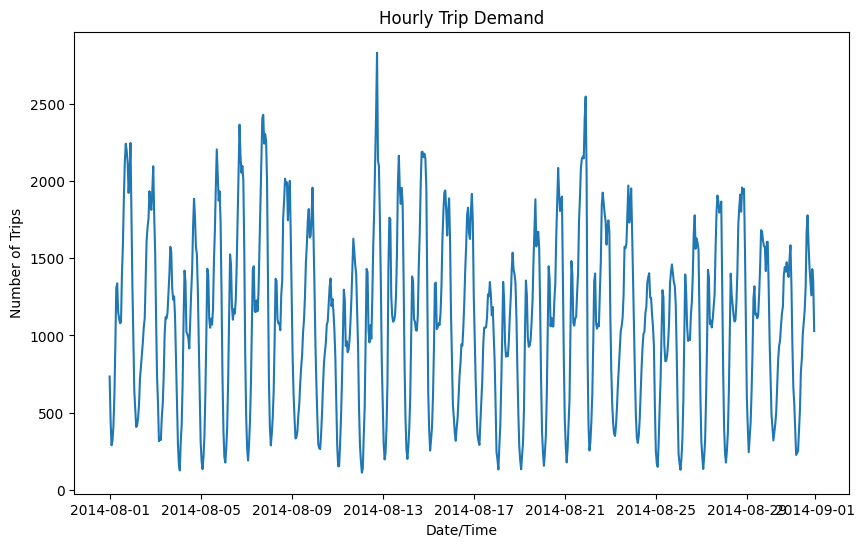

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(x=trip_counts['Date/Time'], y=trip_counts['trips'])
plt.title('Hourly Trip Demand')
plt.xlabel('Date/Time')
plt.ylabel('Number of Trips')
plt.show()
